In [1]:
import warnings
warnings.filterwarnings("ignore")

# Spatial Regression

## Introduction

### *What* is spatial regression and *why* should I care?

Regression (and prediction more generally) provides us a perfect case to examine how spatial structure can help us understand and analyze our data. 
Usually, spatial structure helps models in one of two ways. 
The first (and most clear) way space can have an impact on our data is when the process *generating* the data is itself explicitly spatial.
Here, think of something like the prices for single family homes. 
It's often the case that individuals pay a premium on their house price in order to live in a better school district for the same quality house. 
Alternatively, homes closer to noise or chemical polluters like waste water treatment plants, recycling facilities, or wide highways, may actually be cheaper than we would otherwise anticipate. 
Finally, in cases like asthma incidence, the locations individuals tend to travel to throughout the day, such as their places of work or recreation, may have more impact on their health than their residential addresses. 
In this case, it may be necessary to use data *from other sites* to predict the asthma incidence at a given site. 
Regardless of the specific case at play, here, *geography is a feature*: it directly helps us make predictions about outcomes *because those outcomes obtain from geographical processes*. 

An alternative (and more skeptical understanding) reluctantly acknowledges geography's instrumental value. 
Often, in the analysis of predictive methods and classifiers, we are interested in analyzing what we get wrong.
This is common in econometrics; an analyst may be concerned that the model *systematically* mis-predicts some types of observations.
If we know our model routinely performs poorly on a known set of observations or type of input, we might make a better model if we can account for this. 
Among other kinds of error diagnostics, geography provides us with an exceptionally-useful embedding to assess structure in our errors.
Mapping classification/prediction error can help show whether or not there are *clusters of error* in our data.
If we *know* that errors tend to be larger in some areas than in other areas (or if error is "contagious" between observations), then we might be able to exploit this structure to make better predictions.

Spatial structure in our errors might arise from when geography *should be* an attribute somehow, but we are not sure exactly how to include it in our model. 
They might also arise because there is some *other* feature whose omission causes the spatial patterns in the error we see; if this additional feature were included, the structure would disappear. 
Or, it might arise from the complex interactions and interdependencies between the features that we have chosen to use as predictors, resulting in intrinsic structure in mis-prediction. 
Most of the predictors we use in models of social processes contain *embodied* spatial information: patterning intrinsic to the feature that we get for free in the model. 
If we intend to or not, using a spatially-patterned predictor in a model can result in spatially-patterned errors; using more than one can amplify this effect. 
Thus, *regardless of whether or not the true process is explicitly geographic*, additional information about the spatial relationships between our observations or more information about nearby sites can make our predictions better. 

### The Data: San Diego AirBnB

To learn a little more about how regression works, we'll examine some information about AirBnB in San Diego, CA. 
This dataset contains house intrinsic characteristics, both continuous (number of beds as in `beds`) and categorical (type of renting or, in AirBnB jargon, property group as in the series of `pg_X` binary variables), but also variables that explicitly refer to the location and spatial configuration of the dataset (e.g. distance to Balboa Park, `d2balboa` or neighborhood id, `neighbourhood_cleansed`).

In [2]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn

In [3]:
db = geopandas.read_file('../data/airbnb/regression_db.geojson')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

These are the explanatory variables we will use throughout the chapter.

In [4]:
variable_names = [
    'accommodates', 
    'bathrooms', 
    'bedrooms', 
    'beds', 
    'rt_Private_room', 
    'rt_Shared_room',
    'pg_Condominium', 
    'pg_House', 
    'pg_Other', 
    'pg_Townhouse'
]

## Non-spatial regression, a (very) quick refresh

Before we discuss how to explicitly include space into the linear regression framework, let us show how basic regression can be carried out in Python, and how one can begin to interpret the results. By no means is this a formal and complete introduction to regression so, if that is what you are looking for, we recommend {cite}`Gelman_2006`, in particular chapters 3 and 4, which provide a fantastic, non-spatial introduction.

The core idea of linear regression is to explain the variation in a given (*dependent*) variable as a linear function of a collection of other (*explanatory*) variables. For example, in our case, we may want to express/explain the price of a house as a function of whether it is new and the degree of deprivation of the area where it is located. At the individual level, we can express this as:

$$
P_i = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where $P_i$ is the AirBnB price of house $i$, and $X$ is a set of covariates that we use to explain such price. $\beta$ is a vector of parameters that give us information about in which way and to what extent each variable is related to the price, and $\alpha$, the constant term, is the average house price when all the other variables are zero. The term $\epsilon_i$ is usually referred to as "error" and captures elements that influence the price of a house but are not included in $X$. We can also express this relation in matrix form, excluding subindices for $i$, which yields:

$$
P = \alpha + \mathbf{X}\beta + \epsilon
$$

A regression can be seen as a multivariate extension of bivariate correlations. Indeed, one way to interpret the $\beta_k$ coefficients in the equation above is as the degree of correlation between the explanatory variable $k$ and the dependent variable, *keeping all the other explanatory variables constant*. When one calculates bivariate correlations, the coefficient of a variable is picking up the correlation between the variables, but it is also subsuming into it variation associated with other correlated variables -- also called confounding factors. Regression allows us to isolate the distinct effect that a single variable has on the dependent one, once we *control* for those other variables.

Practically speaking, linear regressions in Python are rather streamlined and easy to work with. There are also several packages which will run them (e.g. `statsmodels`, `scikit-learn`, `PySAL`). In the context of this chapter, it makes sense to start with `PySAL` as that is the only library that will allow us to move into explicitly spatial econometric models. To fit the model specified in the equation above with $X$ as the list defined, we only need the following line of code:

In [5]:
m1 = spreg.OLS(
    db[['log_price']].values, 
    db[variable_names].values,
    name_y='log_price', 
    name_x=variable_names
)

We use the command `OLS`, part of the `spreg` sub-package, and specify the dependent variable (the log of the price, so we can interpret results in terms of percentage change) and the explanatory ones. Note that both objects need to be arrays, so we extract them from the `pandas.DataFrame` object using `.values`.

In order to inspect the results of the model, we can call `summary`:

In [6]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

A full detailed explanation of the output is beyond the scope of this chapter, so we will focus on the relevant bits for our main purpose. This is concentrated on the `Coefficients` section, which gives us the estimates for $\beta_k$ in our model. In other words, these numbers express the relationship between each explanatory variable and the dependent one, once the effect of confounding factors has been accounted for. Keep in mind however that regression is no magic; we are only discounting the effect of confounding factors that we include in the model, not of *all* potentially confounding factors.

Results are largely as expected: houses tend to be significantly more expensive if they accommodate more people (`accommodates`), if they have more bathrooms and bedrooms and if they are a condominium or part of the "other" category of house type. Conversely, given a number of rooms, houses with more beds (i.e.. listings that are more "crowded") tend to go for cheaper, as it is the case for properties where one does not rent the entire house but only a room (`rt_Private_room`) or even shares it (`rt_Shared_room`). Of course, you might conceptually doubt the assumption that it is possible to *arbitrarily* change the number of beds within an AirBnB without eventually changing the number of people it accommodates, but methods to address these concerns using *interaction effects* won't be discussed here. 

### Hidden Structures

In general, our model performs well, being able to predict slightly more than 65% ($R^2=0.67$) of the variation in the mean nightly price using the covariates we've discussed above.
But, our model might display some clustering in errors. 
To interrogate this, we can do a few things. 
One simple concept might be to look at the correlation between the error in predicting an AirBnB and the error in predicting its nearest neighbor. 
To examine this, we first might want to split our data up by regions and see if we've got some spatial structure in our residuals. 
One reasonable theory might be that our model does not include any information about *beaches*, a critical aspect of why people live and vacation in San Diego. 
Therefore, we might want to see whether or not our errors are higher or lower depending on whether or not an AirBnB is in a "beach" neighborhood, a neighborhood near the ocean:

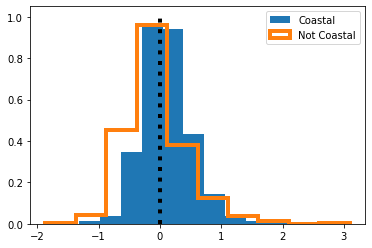

In [7]:
is_coastal = db.coastal.astype(bool)
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
plt.hist(coastal, density=True, label='Coastal')
plt.hist(
    not_coastal, 
    histtype='step',
    density=True, 
    linewidth=4, 
    label='Not Coastal'
)
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
plt.legend()
plt.show()

While it appears that the neighborhoods on the coast have only slightly higher average errors (and have lower variance in their prediction errors), the two distributions are significantly distinct from one another when compared using a classic $t$ test:

In [8]:
stats.ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

There are more sophisticated (and harder to fool) tests that may be applicable for this data, however. We cover them in the [Challenge](#Challenge) section. 

Additionally, it might be the case that some neighborhoods are more desirable than other neighborhoods due to unmodeled latent preferences or marketing. 
For instance, despite its presence close to the sea, living near Camp Pendleton -a Marine base in the North of the city- may incur some significant penalties on area desirability due to noise and pollution. 
For us to determine whether this is the case, we might be interested in the full distribution of model residuals within each neighborhood. 

To make this more clear, we'll first sort the data by the median residual in that neighborhood, and then make a box plot, which shows the distribution of residuals in each neighborhood:

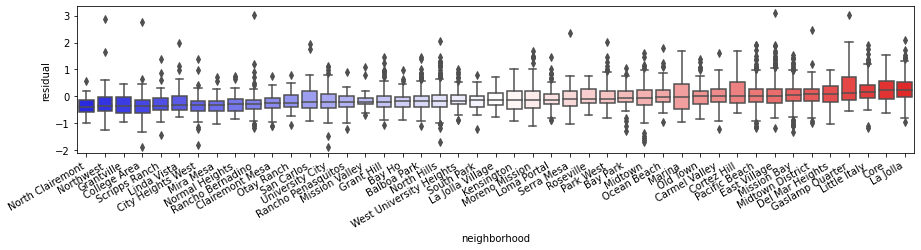

In [9]:
db['residual'] = m1.u
medians = db.groupby(
    "neighborhood"
).residual.median().to_frame(
    'hood_residual'
)

f = plt.figure(figsize=(15,3))
ax = plt.gca()
seaborn.boxplot(
    'neighborhood', 
    'residual', 
    ax = ax,
    data=db.merge(
        medians, 
        how='left',
        left_on='neighborhood',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='bwr'
)
f.autofmt_xdate()
plt.show()

No neighborhood is disjoint from one another, but some do appear to be higher than others, such as the well-known downtown tourist neighborhoods areas of the Gaslamp Quarter, Little Italy, or The Core. 
Thus, there may be a distinctive effect of intangible neighborhood fashionableness that matters in this model. 

Noting that many of the most over- and under-predicted neighborhoods are near one another in the city, it may also be the case that there is some sort of *contagion* or spatial spillovers in the nightly rent price. 
This often is apparent when individuals seek to price their AirBnB listings to compete with similar nearby listings. 
Since our model is not aware of this behavior, its errors may tend to cluster. 
One exceptionally simple way we can look into this structure is by examining the relationship between an observation's residuals and its surrounding residuals. 

To do this, we will use *spatial weights* to represent the geographic relationships between observations. 
We cover spatial weights in detail in another chapter, so we will not repeat ourselves here.
For this example, we'll start off with a $KNN$ matrix where $k=1$, meaning we're focusing only on the linkages of each AirBnB to their closest other listing.

In [10]:
knn = weights.KNN.from_dataframe(db, k=1)

This means that, when we compute the *spatial lag* of that $KNN$ weight and the residual, we get the residual of the AirBnB listing closest to each observation.

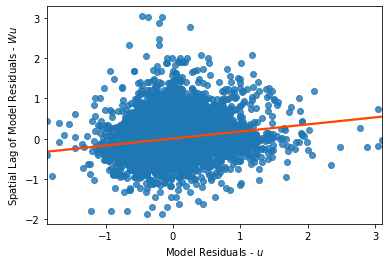

In [11]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

In this plot, we see that our prediction errors tend to cluster!
Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it. 
Here, we're using this nearest site to stand in for the *surroundings* of that AirBnB. 
This means that, when the model tends to over-predict a given AirBnB's nightly log price, sites around that AirBnB are more likely to *also be over-predicted*. 

An interesting property of this relationship is that it tends to stabilize as the number of nearest neighbors used to construct each AirBnB's surroundings increases.
Consult the [Challenge](#Challenge) section for more on this property. 

Given this behavior, let's look at the stable $k=20$ number of neighbors.
Examining the relationship between this stable *surrounding* average and the focal AirBnB, we can even find clusters in our model error. 
Recalling the *local Moran* statistics, we can identify certain areas where our predictions of the nightly (log) AirBnB price tend to be significantly off:

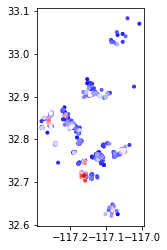

In [12]:
knn.reweight(k=20, inplace=True)
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
error_clusters = (outliers.q % 2 == 1) # only the cluster cores
error_clusters &= (outliers.p_sim <= .001) # filtering out non-significant clusters
db.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
).query(
    "error_clusters"
).sort_values(
    'local_I'
).plot(
    'local_I', cmap='bwr', marker='.'
);

Thus, these areas tend to be locations where our model significantly under-predicts the nightly AirBnB price both for that specific observation and observations in its immediate surroundings. 
This is critical since, if we can identify how these areas are structured &mdash; if they have a *consistent geography* that we can model &mdash; then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas. 

Since significant under- and over-predictions do appear to cluster in a highly structured way, we might be able to use a better model to fix the geography of our model errors. 


## Bringing space into the regression framework

There are many different ways that spatial structure shows up in our models, predictions, and our data, even if we do not explicitly intend to study it.
Fortunately, there are nearly as many techniques, called *spatial regression* methods, that are designed to handle these sorts of structures.
Spatial regression is about *explicitly* introducing space or geographical context into the statistical framework of a regression. 
Conceptually, we want to introduce space into our model whenever we think it plays an important role in the process we are interested in, or when space can act as a reasonable proxy for other factors we cannot but should include in our model. 
As an example of the former, we can imagine how houses at the seafront are probably more expensive than those in the second row, given their better views. 
To illustrate the latter, we can think of how the character of a neighborhood is important in determining the price of a house; however, it is very hard to identify and quantify "character" *per se,* although it might be easier to get at its spatial variation, hence a case of space as a proxy.

Spatial regression is a large field of development in the econometrics and statistics literatures. 
In this brief introduction, we will consider two related but very different processes that give rise to spatial effects: spatial heterogeneity and spatial dependence. 
For more rigorous treatments of the topics introduced here, the reader is
referred to {cite}`Anselin_2003,Anselin_2014,Gelman_2006`.

### Spatial Feature Engineering

Using geographic information to "construct" new data is a common approach to bring in spatial information into geographic analysis. 
Often, this reflects the fact that processes are not the same everywhere in the map of analysis, or that geographical information may be useful to predict our outcome of interest. In this section, we will briefly present how to use *spatial features*, or $X$ variables that are constructed from geographical relationships, in a standard linear model. We discuss spatial feature engineering extensively in the next chapter, though, and the depth and extent of spatial feature engineering is difficult to overstate. In this, we will consider only the simplest of spatial features: proximity variables. 

#### Proximity variables

For a start, one relevant proximity-driven variable that could influence our model is based on the listings proximity to Balboa Park. A common tourist destination, Balboa park is a central recreation hub for the city of San Diego, containing many museums and the San Diego zoo. Thus, it could be the case that people searching for AirBnBs in San Diego are willing to pay a premium to live closer to the park. If this were true *and* we omitted this from our model, we may indeed see a significant spatial pattern caused by this distance decay effect. 

Therefore, this is sometimes called a *spatially-patterned omitted covariate*: geographic information our model needs to make good predictions which we have left out of our model. Therefore, let's build a new model containing this distance to Balboa Park covariate. First, though, it helps to visualize the structure of this distance covariate itself:

<AxesSubplot:>

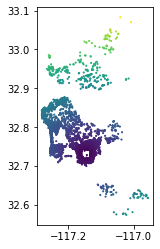

In [13]:
db.plot('d2balboa', marker='.', s=5)

In [14]:
base_names = variable_names
balboa_names = variable_names + ['d2balboa']

In [15]:
m2 = spreg.OLS(
    db[['log_price']].values, 
    db[balboa_names].values, 
    name_y = 'log_price', 
    name_x = balboa_names
)

Unfortunately, when you inspect the regression diagnostics and output, you see that this covariate is not quite as helpful as we might anticipate. It is not statistically significant at conventional significance levels, the model fit does not substantially change:

In [16]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
R-squared           :      0.6685
Adjusted R-squared  :      0.6679
Sum squared residual:    1319.522                F-statistic           :   1117.9338
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3987.446
Sigma-square ML     :       0.216                Akaike info criterion :    7998.892
S.E of regression ML:      0.4647                Schwarz criterion     :    8079.504

-----------------------------------------------------------------------------

And, there still appears to be spatial structure in our model's errors:

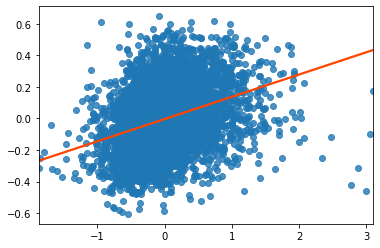

In [17]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
seaborn.regplot(
    m2.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
);

Finally, the distance to Balboa Park variable does not fit our theory about how distance to amenity should affect the price of an AirBnB; the coefficient estimate is *positive*, meaning that people are paying a premium to be *further* from the Park. We will revisit this result later on, when we consider spatial heterogeneity and will be able to shed some light on this. Further, the next chapter is an extensive treatment of spatial fixed effects, presenting many more spatial feature engineering methods. Here, we have only showed how to include these engineered features in a standard linear modeling framework. 

### Spatial Heterogeneity

While we've assumed that our proximity variable might stand in for a difficult-to-measure premium individuals pay when they're close to a recreational zone. However, not all neighborhoods are created equal; some neighborhoods may be more lucrative than others, regardless of their proximity to Balboa Park. When this is the case, we need some way to account for the fact that each neighborhood may experience these kinds of *gestalt*, unique effects. One way to do this is by capturing *spatial heterogeneity*. At its most basic, *spatial heterogeneity* means that parts of the model may change in different places. For example, changes to the intercept, $\alpha$, may reflect the fact that different areas have different baseline exposures to a given process. Changes to the slope terms, $\beta$, may indicate some kind of geographical mediating factor, such as when a governmental policy is not consistently applied across jurisdictions. Finally, changes to the variance of the residuals, commonly denoted $\sigma^2$, can introduce spatial heteroskedasticity. We deal with the first two in this section. 

To illustrate spatial fixed effects, let us consider the house price example from the previous section to introduce a more general illustration for "space as a proxy". Given we are only including two explanatory variables in the model, it is likely we are missing some important factors that play a role at determining the price at which a house is sold. Some of them, however, are likely to vary systematically over space (e.g. different neighborhood characteristics). If that is the case, we can control for those unobserved factors by using traditional dummy variables but basing their creation on a spatial rule. For example, let us include a binary variable for every neighborhood, indicating whether a given house is located within such area (`1`) or not (`0`). Mathematically, we are now fitting the following equation:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

where the main difference is that we are now allowing the constant term, $\alpha$, to vary by neighborhood $r$, $\alpha_r$.

Programmatically, we will show two different ways can estimate this: one,
using `statsmodels`; and two, with `PySAL`. First, we will use `statsmodels`. This package provides a formula-like API, which allows us to express the *equation* we wish to estimate directly:

In [18]:
f = 'log_price ~ ' + ' + '.join(variable_names) + ' + neighborhood - 1'
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


The *tilde* operator in this statement is usually read as "log price is a function of ...", to account for the fact that many different model specifications can be fit according to that functional relationship between `log_price` and our covariate list. Critically, note that the trailing `-1` term means that we are fitting this model without an intercept term. This is necessary, since including an intercept term alongside unique means for every neighborhood would make the underlying system of equations underspecified.  

Using this expression, we can estimate the unique effects of each neighborhood, fitting the model in `statsmodels`: 

In [19]:
m3 = sm.ols(f, data=db).fit()
print(m3.summary2())

                           Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.709    
Dependent Variable:         log_price              AIC:                      7229.6640
Date:                       2021-05-12 16:45       BIC:                      7599.1365
No. Observations:           6110                   Log-Likelihood:           -3559.8  
Df Model:                   54                     F-statistic:              276.9    
Df Residuals:               6055                   Prob (F-statistic):       0.00     
R-squared:                  0.712                  Scale:                    0.18946  
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------------
neighborhood[Balboa Park]              4.2808   0.0333 128.5836 0.0000 

The approach above shows how spatial FE are a particular case of a linear regression with a categorical  variable. Neighborhood membership is modeled using binary dummy variables. Thanks to the formula grammar used in `statsmodels`, we can express the model abstractly, and Python parses it, appropriately creating binary variables as required.

The second approach leverages `PySAL` Regimes functionality, which allows the user to specify which variables are to be estimated separately for each "regime". In this case however, instead of describing the model in a formula, we need to pass each element of the model as separate arguments.

In [20]:
# PySAL implementation
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['neighborhood'].tolist(),
    constant_regi='many',
    cols2regi=[False]*len(variable_names),
    regime_err_sep=False,
    name_y='log_price', 
    name_x=variable_names
)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          55
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6055
R-squared           :      0.7118
Adjusted R-squared  :      0.7092
Sum squared residual:    1147.169                F-statistic           :    276.9408
Sigma-square        :       0.189                Prob(F-statistic)     :           0
S.E. of regression  :       0.435                Log likelihood        :   -3559.832
Sigma-square ML     :       0.188                Akaike info criterion :    7229.664
S.E of regression ML:      0.4333                Schwarz criterion     :    7599.137

---------------------------------------------------------

Econometrically speaking, what the neighborhood FEs we have introduced imply is that, instead of comparing all house prices across San Diego as equal, we only derive variation from within each postcode. Remember that the interpretation of $\beta_k$ is the effect of variable $k$, *given all the other explanatory variables included remain constant*. By including a single variable for each area, we are effectively forcing the model to compare as equal only house prices that share the same value for each variable; or, in other words, only houses located within the same area. Introducing FE affords a higher degree of isolation of the effects of the variables we introduce in the model because we can control for unobserved effects that align spatially with the distribution of the FE introduced (by postcode, in our case).

To make a map of neighborhood fixed effects, we need to process the results from our model slightly.

First, we extract only the effects pertaining to the neighborhoods:

In [21]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

Then, we need to extract just the neighborhood name from the index of this Series. A simple way to do this is to strip all the characters that come before and after our neighborhood names:

In [22]:
stripped = neighborhood_effects.index.str.strip('neighborhood[').str.strip(']')
neighborhood_effects.index = stripped
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


Good, we're back to our raw neighborhood names. Now, we can join them back up with the neighborhood shapes:

In [23]:
sd_path = '../data/airbnb/neighbourhoods.geojson'
neighborhoods = geopandas.read_file(sd_path)

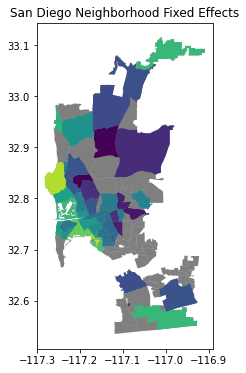

In [24]:
ax = neighborhoods.plot(
    color='k', alpha=0.5, figsize=(12,6)
)
neighborhoods.merge(
    neighborhood_effects, 
    how='left',
    left_on='neighbourhood', 
    right_index=True
).dropna(
    subset=['fixed_effect']
).plot(
    'fixed_effect', ax=ax
)
ax.set_title("San Diego Neighborhood Fixed Effects")
plt.show()

#### Spatial Regimes

At the core of estimating spatial FEs is the idea that, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. In other words, spatial FEs introduce econometrically the notion of spatial heterogeneity. They do this in the simplest possible form: by allowing the constant term to vary geographically. The other elements of the regression are left untouched and hence apply uniformly across space. The idea of spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable. This implies that the equation we will be estimating is:

$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

where we are not only allowing the constant term to vary by region ($\alpha_r$), but also every other parameter ($\beta_{k-r}$).

To illustrate this approach, we will use the "spatial differentiator" of whether a house is in a coastal neighborhood or not (`coastal_neig`) to define the regimes. The rationale behind this choice is that renting a house close to the ocean might be a strong enough pull that people might be willing to pay at different *rates* for each of the house's characteristics.

To implement this in Python, we use the `OLS_Regimes` class in `PySAL`, which does most of the heavy lifting for us:

In [25]:
m4 = spreg.OLS_Regimes(
    db[['log_price']].values, 
    db[variable_names].values,
    db['coastal'].tolist(),
    constant_regi='many',
    regime_err_sep=False,
    name_y='log_price', 
    name_x=variable_names
)
print(m4.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          22
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6088
R-squared           :      0.6853
Adjusted R-squared  :      0.6843
Sum squared residual:    1252.489                F-statistic           :    631.4283
Sigma-square        :       0.206                Prob(F-statistic)     :           0
S.E. of regression  :       0.454                Log likelihood        :   -3828.169
Sigma-square ML     :       0.205                Akaike info criterion :    7700.339
S.E of regression ML:      0.4528                Schwarz criterion     :    7848.128

---------------------------------------------------------

### Spatial Dependence

As we have just discussed, SH is about effects of phenomena that are *explicitly linked*
to geography and that hence cause spatial variation and clustering. This
encompasses many of the kinds of spatial effects we may be interested in when we fit
linear regressions. However, in other cases, our focus is on the effect of the *spatial
configuration* of the observations, and the extent to which that has an effect on the
outcome we are considering. For example, we might think that the price of a house not
only depends on whether it is a townhouse or an apartment, but also on
whether it is surrounded by many more townhouses than skyscrapers with more
apartments. This, we could hypothesize, might be related to the different "look and feel" a
neighborhood with low-height, historic buildings has as compared to one with
modern high-rises. To the extent these two different spatial configurations
enter differently the house price determination process, we will be
interested in capturing not only the characteristics of a house, but also of
its surrounding ones.
This kind of spatial effect is fundamentally different
from SH in that is it not related to inherent characteristics of the geography but relates 
to the characteristics of the observations in our dataset and, specially, to their spatial
arrangement. We call this phenomenon by which the values of observations are related to
each other through distance *spatial dependence* {cite}`Anselin_1988`.

There are several ways to introduce spatial dependence in an econometric
framework, with varying degrees of econometric sophistication (see
{cite}`Anselin_2002` for a good overview). Common to all of them however is the way space is
formally encapsulated: through *spatial weights matrices ($\mathbf{W}$)*, which we discussed in Chapter 4.

#### Exogenous effects: The SLX Model

Let us come back to the house price example we have been working with. So far, we
have hypothesized that the price of a house rented in San Diego through AirBnB can
be explained using information about its own characteristics as well as some 
relating to its location such as the neighborhood or the distance to the main
park in the city. However, it is also reasonable to think that prospective renters
care about the larger area around a house, not only about the house itself, and would
be willing to pay more for a house that was surrounded by certain types of houses, 
and less if it was located in the middle of other types. How could we test this idea?

The most straightforward way to introduce spatial dependence in a regression is by 
considering not only a given explanatory variable, but also its spatial lag. In our
example case, in addition to including a dummy for the type of house (`pg_XXX`), we 
can also include the spatial lag of each type of house. This addition implies
we are also including as explanatory factor of the price of a given house the proportion 
neighboring houses in each type. Mathematically, this implies estimating the following model:

$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

where $\sum_{j=1}^N w_{ij}x_{jk}$ represents the spatial lag of the $k$th explanatory variable.
This can be stated in *matrix* form using the spatial weights matrix, $\mathbf{W}$, as:
$$
\log(P_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

This splits the model to focus on two main effects: $\beta$ and $\gamma$. The
$\beta$ effect describes the change in $y_i$ when $X_{ik}$ changes by one. 
^[Since we use the log price for a $y$ variable, our
$\beta$ coefficients are still all interpreted as *elasticities*, meaning that a
unit change in the $x_i$ variate results in a $\beta$ percent change in the
price *y_i*]. The subscript for site $i$ is important here: since we're dealing 
with a $\mathbf{W}$ matrix, it's useful to be clear about where the change occurs. 

Indeed, this matters for the $\gamma$ effect, which represents an 
*indirect* effect of a change in $X_i$. This can be conceptualized in two ways. 
First, one could think of $\gamma$ as simply *the effect of a unit change in your average surroundings.*
This is useful and simple. But, this interpretation ignores where this change
might occur. In truth, a change in a variable at site $i$ will result in a *spillover* to its surroundings:
when $x_i$ changes, so too does the *spatial lag* of any site near $i$. 
The precise size of this will depend on the structure of $\mathbf{W}$, and can be 
different for every site. For example, think of a very highly-connected "focal" site in a 
row-standardized weight matrix. This focal site will not be strongly affected 
if a neighbor changes by a single unit, since each site only contributes a 
small amount to the lag at the focal site. Alternatively, consider a site with only 
one neighbor: its lag will change by *exactly* the amount its sole neighbor changes.
Thus, to discover the exact indirect effect of a change $y$ caused by the change
at a specific site $x_i$ you would need to compute the *change in the spatial lag*,
and then use that as your *change* in $X$. We will discuss this in the following section. 

In Python, we can calculate the spatial lag of each variable whose name starts by `pg_`
by first creating a list of all of those names, and then applying `PySAL`'s
`lag_spatial` to each of them:

In [26]:
wx = db.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)

Once computed, we can run the model using OLS estimation because, in this
context, the spatial  lags included do not violate any of the assumptions OLS
relies on (they are essentially additional exogenous variables):

In [27]:
slx_exog = db[variable_names].join(wx)
m5 = spreg.OLS(
    db[['log_price']].values, 
    slx_exog.values,
    name_y='l_price', 
    name_x=slx_exog.columns.tolist()
)
print(m5.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     l_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          15
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6095
R-squared           :      0.6800
Adjusted R-squared  :      0.6792
Sum squared residual:    1273.933                F-statistic           :    924.9423
Sigma-square        :       0.209                Prob(F-statistic)     :           0
S.E. of regression  :       0.457                Log likelihood        :   -3880.030
Sigma-square ML     :       0.208                Akaike info criterion :    7790.061
S.E of regression ML:      0.4566                Schwarz criterion     :    7890.826

-----------------------------------------------------------------------------

The way to interpret the table of results is similar to that of any other
non-spatial regression. The variables we included in the original regression
display similar behavior, albeit with small changes in size, and can be
interpreted also in a similar way. The spatial lag of each type of property
(`w_pg_XXX`) is the new addition. We observe that, except for the case
of townhouses (same as with the binary variable, `pg_Townhouse`), they are all
significant, suggesting our initial hypothesis on the role of the surrounding
houses might indeed be at work here. 

As an illustration, let's look at some of the direct/indirect effects. 
The direct effect of the `pg_Condominium` variable means that condominiums are
typically 11% more expensive ($\beta_{pg\_Condominium}=0.1063$) than the benchmark
property type, apartments. More relevant to this section, any given house surrounded by 
condominiums *also* receives a price premium. But, since $pg_Condominium$ is a dummy variable,
the spatial lag at site $i$ represents the *percentage* of properties near $i$ that are
condominiums, which is between $0$ and $1$.^[Discover this for yourself: what is the average of `numpy.array([True, True, True, False, False, True)]`?]
So, a *unit* change in this variable means that you would increase the condominium 
percentage by 100%. Thus, a $.1$ increase in `w_pg_Condominium` (a change of ten percentage points)
would result in a 5.92% increase in the property house price ($\beta_{w_pg\_Condominium} = 0.6$). 
Similar interpretations can be derived for all other spatially lagged variables to derive the
*indirect* effect of a change in the spatial lag. 

However, to compute the indirect change for a given site $i$, you may need to examine the predicted values for $y_i$. In this example, since we are using a row-standardized weights matrix with twenty nearest neighbors, the impact of changing $x_i$ is the same for all of its neighbors and for any site $i$. Thus, the effect is always $\frac{\gamma}{20}$, or about $0.0296$. However, this would not be the same for many other kinds of weights (like `Kernel`, `Queen`, `Rook`, `DistanceBand`, or `Voronoi`), so we will demonstrate how to construct the indirect effect for a specific $i$:

First, predicted values for $y_i$ are stored in the `predy` attribute of any model:

In [28]:
m5.predy

array([[5.43610121],
       [5.38596868],
       [4.25377454],
       ...,
       [4.29145318],
       [4.89174746],
       [4.85867698]])

To build new predictions, we need to follow the equation stated above.

Showing this process below, let's first change a property to be a condominium. Consider the third observation, which is the first apartment in the data:

In [29]:
db.loc[2]

accommodates                                                     2
bathrooms                                                      1.0
bedrooms                                                       1.0
beds                                                           1.0
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                  2.493893
coastal                                                          0
price                                                         99.0
log_price                                                  4.59512
id                                                            9553
pg_Apartment                                                     1
pg_Condominium                                                   0
pg_House                                                         0
pg_Other                                                      

This is an apartment. Let's make a copy of our data and change this apartment into a condominium:

In [30]:
db_scenario = db.copy()
# make Apartment 0 and condo 1
db_scenario.loc[2, ['pg_Apartment', 'pg_Condominium']] = [0,1]

We've successfully made the change:

In [31]:
db_scenario.loc[2]

accommodates                                                     2
bathrooms                                                      1.0
bedrooms                                                       1.0
beds                                                           1.0
neighborhood                                           North Hills
pool                                                             0
d2balboa                                                  2.493893
coastal                                                          0
price                                                         99.0
log_price                                                  4.59512
id                                                            9553
pg_Apartment                                                     0
pg_Condominium                                                   1
pg_House                                                         0
pg_Other                                                      

Now, we need to *also* update the spatial lag variates:

In [32]:
wx_scenario = db_scenario.filter(
    like='pg'
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
).rename(
    columns=lambda c: 'w_'+c
).drop(
    'w_pg_Apartment', axis=1
)

And build a new exogenous $\mathbf{X}$ matrix, including the a constant 1 as the leading column

In [33]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)

Now, our new prediction (in the scenario where we have changed site `2` from an apartment into a condominium), is:

In [34]:
y_pred_scenario = m5.betas[0] + slx_exog_scenario @ m5.betas[1:]

This prediction will be exactly the same for all sites, except site `2` and its neighbors. So, the *neighbors* to site `2` are:

In [35]:
knn.neighbors[2]

[772,
 2212,
 139,
 4653,
 2786,
 1218,
 138,
 808,
 1480,
 4241,
 1631,
 3617,
 2612,
 1162,
 135,
 23,
 5528,
 3591,
 407,
 6088]

And the effect of changing site `2` into a condominium is associated with the following changes to $y_i$:

In [36]:
(y_pred_scenario - m5.predy).loc[[2] + knn.neighbors[2]]

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


We see the first row, representing the direct effect, is equal exactly to the estimate for `pg_Condominium`. For the other effects, though, we have only changed `w_pg_Condominium` by $.05$

In [37]:
scenario_near_2 = slx_exog_scenario.loc[knn.neighbors[2], ['w_pg_Condominium']]
orig_near_2 = slx_exog.loc[knn.neighbors[2], ['w_pg_Condominium']]
scenario_near_2.join(orig_near_2, lsuffix='_scenario', rsuffix= '_original')

,w_pg_Condominium_scenario,w_pg_Condominium_original
772,0.10,0.05
2212,0.10,0.05
139,0.10,0.05
4653,0.10,0.05
2786,0.10,0.05
1218,0.10,0.05
138,0.10,0.05
808,0.05,0.00
1480,0.10,0.05
4241,0.10,0.05


Introducing a spatial lag of an explanatory variable, as we have just seen, is the most straightforward way of incorporating the notion of spatial dependence in a linear regression framework. It does not require additional changes, it can be estimated with OLS, and the interpretation is rather similar to interpreting non-spatial variables, so long as aggregate changes are required. 

The field of spatial econometrics however is a much broader one and has produced over the last decades many techniques to deal with spatial effects and spatial dependence in different ways. Although this might be an over simplification, one can say that most of such efforts for the case of a single cross-section are focused on two main variations: the spatial lag and the spatial error model. Both are similar to the case we have seen in that they are based on the introduction of a spatial lag, but they differ in the component of the model they modify and affect.

#### Spatial Error

The spatial error model includes a spatial lag in the *error* term of the equation:

$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 
Although it appears similar, this specification violates the assumptions about the
error term in a classical OLS model. Hence, alternative estimation methods are
required. `PySAL` incorporates functionality to estimate several of the most
advanced techniques developed by the literature on spatial econometrics. For
example, we can use a general method of moments that account for 
heterogeneity (Arraiz et al., 2010):

In [38]:
m6 = spreg.GM_Error_Het(
    db[['log_price']].values, 
    db[variable_names].values,
    w=knn, 
    name_y='log_price', 
    name_x=variable_names
)
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
Pseudo R-squared    :      0.6655
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       4.4262033       0.0217088     203.8898738       0.0000000
        accommodates       0.0695536       0.0063268      10.9934495       0.00

#### Spatial Lag

The spatial lag model introduces a spatial lag of the *dependent* variable. In the example we have covered, this would translate into:

$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

Although it might not seem very different from the previous equation, this model violates 
the exogeneity assumption, crucial for OLS to work. 
Put simply, this occurs when $P_i$ exists on both "sides" of the equals sign.
In theory, since $P_i$ is included in computing $P_{lag-i}$, exogeneity is violated. 
Similarly to the case of
the spatial error, several techniques have been proposed to overcome this
limitation, and `PySAL` implements several of them. In the example below, we
use a two-stage least squares estimation {cite}`Anselin_1988`, where the spatial
lag of all the explanatory variables is used as instrument for the endogenous
lag:

In [39]:
m7 = spreg.GM_Lag(
    db[['log_price']].values, 
    db[variable_names].values,
    w=knn, 
    name_y='log_price', 
    name_x=variable_names
)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
Pseudo R-squared    :      0.7057
Spatial Pseudo R-squared:  0.6883

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       2.7440254       0.0727290      37.7294400       0.0000000
        accommodates       0.0697596       0.0048157      14.4859187       0.0000000
           bathrooms       0.1626725       0.0104007      1

Similarly to the effects in the SLX regression, changes in the spatial lag regression need to be interpreted with care. Here, `w_log_price` applies consistently over all observations, and actually changes the effective strength of each of the $\beta$ coefficients. Thus, it is useful to use predictions and scenario-building to predict $y$ when changing $X$, which allows you to analyze the *direct* and *indirect* components. 

#### Other ways of bringing space into regression

While these are some kinds of spatial regressions, many other advanced spatial regression methods see routine use in statistics, data science, and applied analysis. For example, Generalized Additive Models {cite}`Gibbons_2015,Wood_2006` haven been used to apply spatial kernel smoothing directly within a regression function. Other similar smoothing methods, such as spatial Gaussian process models {cite}`Brunsdon_2010` or Kriging, conceptualize the dependence between locations as smooth as well. Other methods in spatial regression that consider graph-based geographies (rather than distance/kernel effects) include variations on conditional autoregressive model, which examines spatial relationships at locations *conditional* on their surroundings, rather than as jointly co-emergent with them. Full coverage of these topics is beyond the scope of this book, however, though {cite}`Banerjee_2008` provides a detailed and comprehensive discussion. 

## Questions

1. One common kind of spatial econometric model is the "Spatial Durbin Model," which combines the SLX model with the spatial lag model. Alternatively, the "Spatial Durbin Error Model" combines the SLX model with the spatial error model. Fit a Spatial Durbin variant of the spatial models fit in this chapter. 
    - Do these variants improve the model fit?
    - What happens to the spatial autocorrelation parameters ($\rho$, $\lambda$) when the SLX term is added? Why might this occur?
2. Fortunately for us, spatial error models recover the same estimates (asymptotically) as a typical OLS estimate, although their confidence intervals will change. Statistically, this occurs because OLS is *inefficient* when there is spatial correlation and/or spatial heteroskedasticity. How much do the confidence intervals change when the spatial error model is fit?
3. One common justification for the SLX model (and the Spatial Durbin variants) is about *omitted, spatially-patterned variables*. That is, if an omitted variable is associated with the included variables *and* is spatially-patterned, then we can use the spatial structure of our existing variables to mimic the omitted variable. In our spatial lag model, 
    - what variables might we be missing that are important to predict the price of an AirBnB?
    - would these omitted variables have a similar spatial pattern to our included variables? why or why not? 
4. Where *spatial* regression models generally focus on how nearby observations are similar to one another, *platial* models focus on how observations in the same spatial group are similar to one another. These are often dealt with using multilevel or spatial mixed-effect models. When do these two ideas work together well? And, when might these disagree?

### Challenge Questions

The following discussions are a bit challenging, but reflect extra enhancements to the discussions in the chapter that may solidify or enhance an advanced understanding of the material.   

#### The random coast
In the section analyzing our naive model residuals, we ran a classic two-sample $t$-test to identify whether or not our coastal and not-coastal residential districts tended to have the same prediction errors. Often, though, it's better to use straightforward, data-driven testing and simulation methods than assuming that the mathematical assumptions of the $t$-statistic are met.

To do this, we can shuffle our assignments to coast and not-coast, and check whether or not there are differences in the distributions of the *observed* residual distributions and random distributions. In this way, we shuffle the observations that are on the coast, and plot the resulting cumulative distributions.

Below, we do this; running 100 simulated re-assignments of districts to either "coast" or "not coast," and comparing the distributions of randomly-assigned residuals to the observed distributions of residuals. Further, we do this plotting by the *empirical cumulative density function*, not the histogram directly. This is because the *empirical cumulative density function* is usually easier to examine visually, especially for subtle differences. 

Below, the black lines represent our simulations, and the colored patches below them represents the observed distribution of residuals. If the black lines tend to be on the left of the colored patch, then, the simulations (where prediction error is totally random with respect to our categories of "coastal" and "not coastal") tend to have more negative residuals than our actual model. If the black lines tend to be on the right, then they tend to have more positive residuals. As a refresher, positive residuals mean that our model is under-predicting, and negative residuals mean that our model is over-predicting. Below, our simulations provide direct evidence for the claim that our model may be systematically under-predicting coastal price and over-predicting non-coastal prices. 

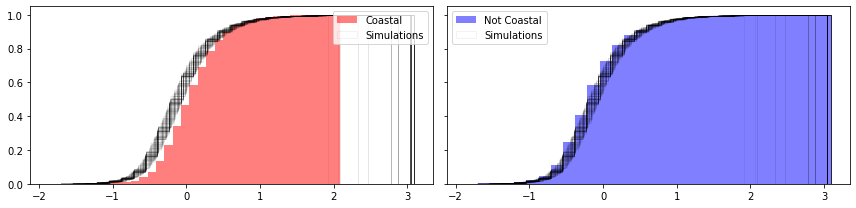

In [40]:
n_simulations = 100
f, ax = plt.subplots(1,2,figsize=(12,3), sharex=True, sharey=True)
ax[0].hist(
    coastal, 
    color='r', 
    alpha=.5, 
    density=True, 
    bins=30, 
    label='Coastal', 
    cumulative=True
)
ax[1].hist(
    not_coastal, 
    color='b', 
    alpha=.5,
    density=True, 
    bins=30, 
    label='Not Coastal', 
    cumulative=True
)
for simulation in range(n_simulations):
    shuffled_residuals = m1.u[numpy.random.permutation(m1.n)]
    random_coast, random_notcoast = (
        shuffled_residuals[is_coastal], 
        shuffled_residuals[~is_coastal]
    )
    if simulation == 0:
        label = 'Simulations'
    else:
        label = None
    ax[0].hist(
        random_coast, 
        density=True, 
        histtype='step',
        color='k', alpha=.05, bins=30, 
        label=label, 
        cumulative=True
    )
    ax[1].hist(
        random_coast, 
        density=True, 
        histtype='step',
        color='k', alpha=.05, bins=30, 
        label=label, 
        cumulative=True
    )
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

#### The K-neighbor correlogram

Further, it might be the case that spatial dependence in our mis-predictions only matters for sites that are extremely close to one another, and decays quickly with distance. 
To investigate this, we can examine the correlation between each sites' residual and the *average* of the $k$th nearest neighbors' residuals, increasing $k$ until the estimate stabilizes. 
This main idea is central to the geostatistical concept, the *correlogram*, which gives the correlation between sites of an attribute being studied as distance increases.

One quick way to check whether or not what we've seen is *unique* or *significant* is to compare it to what happens when we just assign neighbors randomly. 
If what we observe is substantially different from what emerges when neighbors are random, then the structure of the neighbors embeds a structure in the residuals. 
We won't spend too much time on this theory specifically, but we can quickly and efficiently compute the correlation between our observed residuals and the spatial lag of an increasing $k$-nearest neighbor set:

In [41]:
correlations = []
nulls = []
for order in range(1, 51, 5):
    knn.reweight(k=order, inplace=True) #operates in place, quickly and efficiently avoiding copies
    knn.transform = 'r'
    lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
    random_residual = m1.u[numpy.random.permutation(len(m1.u))] 
    random_lag_residual = weights.spatial_lag.lag_spatial(
        knn, random_residual
    ) # identical to random neighbors in KNN 
    correlations.append(
        numpy.corrcoef(m1.u.flatten(), lag_residual.flatten())[0,1]
    )
    nulls.append(
        numpy.corrcoef(m1.u.flatten(), random_lag_residual.flatten())[0,1]
    )

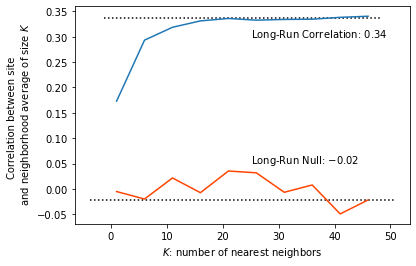

In [42]:
plt.plot(range(1,51,5), correlations)
plt.plot(range(1,51,5), nulls, color='orangered')
plt.hlines(numpy.mean(correlations[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.hlines(numpy.mean(nulls[-3:]),*plt.xlim(),linestyle=':', color='k')
plt.text(s='Long-Run Correlation: ${:.2f}$'.format(numpy.mean(correlations[-3:])), x=25,y=.3)
plt.text(s='Long-Run Null: ${:.2f}$'.format(numpy.mean(nulls[-3:])), x=25, y=.05)
plt.xlabel('$K$: number of nearest neighbors')
plt.ylabel("Correlation between site \n and neighborhood average of size $K$")
plt.show()

Clearly, the two curves are different. The observed correlation reaches a peak around $r=.34$ when around 20 nearest listings are used. This means that adding more than 20 nearest neighbors does not significantly change the correlation in the residuals. Further, the lowest correlation is for the single nearest neighbor, and correlation rapidly increases as more neighbors are added close to the listing. Thus, this means that there does appear to be an unmeasured spatial structure in the residuals, since they are more similar to one another when they are near than when they are far apart. Further, while it's not shown here (since computationally, it becomes intractable), as the number of nearest neighbors gets very large (approaching the number of observations in the dataset), the average of the $k$th nearest neighbors' residuals goes to zero, the global average of residuals. This means that the correlation of the residuals and a vector that is nearly constant begins to approach zero. 

The null correlations, however, use randomly-chosen neighbors (without reassignment).
Thus, since sampling is truly random in this case, each average of $k$ randomly-chosen neighbors is usually zero (the global mean). 
So, the correlation between the observed residual and the average of $k$ randomly-chosen residuals is also usually zero. 
Thus, increasing the number of randomly-chosen neighbors does not significantly adjust the long-run average of zero.
Taken together, we can conclude that there is distinct positive spatial dependence in the error. 
This means that our over- and under-predictions are likely to cluster. 